# Spark SQL 기반 탐색적 데이터 분석 (EDA)

## 학습 목표
1. 데이터 준비 및 테이블 생성
2. 데이터 탐색 및 변환
3. Temporary View 생성 및 활용
4. 데이터 분석 및 시각화
5. 데이터 결합 및 집계

In [26]:
!pip install koreanize-matplotlib

In [2]:
import os
import sys
import gdown
from pyspark.sql import SparkSession
from pyspark.sql.functions import rand

# Colab 환경인지 확인
IN_COLAB = "google.colab" in sys.modules
# Colab이면 /content, 아니면 현재 작업 디렉토리를 BASE로 설정
BASE = "/content" if IN_COLAB else os.getcwd()

# SparkSession 생성 (PySpark 애플리케이션의 진입점)
spark = SparkSession.builder.appName("Spark_SQL_EDA").getOrCreate()

## 1. 데이터 준비 및 테이블 생성

### MovieRatings 테이블
- 사용자가 제출한 2천만 개가 조금 넘는 영화 등급 레코드
- 타임스탬프는 UTC 시간으로 기록된 integer 값

In [3]:
# Colab에서 데이터 다운로드 및 압축 해제
if IN_COLAB:
    file_id = "1NVStzGl0JTWz3ELPKhNV3nVpPm7W2aB0"
    gdown.download(f"https://drive.google.com/uc?id={file_id}", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1NVStzGl0JTWz3ELPKhNV3nVpPm7W2aB0
From (redirected): https://drive.google.com/uc?id=1NVStzGl0JTWz3ELPKhNV3nVpPm7W2aB0&confirm=t&uuid=e7165c07-2233-4aa2-95b4-738dca0aaf5f
To: /content/ratings.csv
100%|██████████| 710M/710M [00:09<00:00, 75.8MB/s]


In [4]:
# movieRatings 테이블 생성

# ratings.csv 파일 경로 설정
RATINGS_PATH = os.path.join(BASE, "ratings.csv")

# 기존 movieRatings 테이블이 있으면 삭제
spark.sql("DROP TABLE IF EXISTS movieRatings")

# 새로운 movieRatings 테이블 생성 및 CSV 데이터 로드
spark.sql(f"""
CREATE TABLE movieRatings (
  userId INT,           -- 사용자 ID
  movieId INT,          -- 영화 ID
  rating FLOAT,         -- 평점 (실수형)
  timeRecorded INT      -- 평점 기록 시간 (타임스탬프)
)
USING csv               -- CSV 형식 사용
OPTIONS (
  path '{RATINGS_PATH}',  -- 파일 경로
  header 'true'           -- 첫 번째 행을 헤더로 사용
)
""")

DataFrame[]

In [5]:
# 테이블 확인
spark.sql("SELECT * FROM movieRatings").limit(5).show()

+------+-------+------+------------+
|userId|movieId|rating|timeRecorded|
+------+-------+------+------------+
|     1|    110|   1.0|  1425941529|
|     1|    147|   4.5|  1425942435|
|     1|    858|   5.0|  1425941523|
|     1|   1221|   5.0|  1425941546|
|     1|   1246|   5.0|  1425941556|
+------+-------+------+------------+



In [6]:
# 전체 레코드 수
spark.sql("SELECT COUNT(*) FROM movieRatings").show()

+--------+
|count(1)|
+--------+
|26024289|
+--------+



## 2. 데이터 탐색 및 변환

### CAST를 사용한 타임스탬프 변환

In [7]:
# timeRecorded를 timestamp 형식으로 변환
spark.sql("""
SELECT
    rating,
    CAST(timeRecorded AS timestamp) AS timestamp
FROM movieRatings
""").limit(5).show()

+------+-------------------+
|rating|          timestamp|
+------+-------------------+
|   1.0|2015-03-09 22:52:09|
|   4.5|2015-03-09 23:07:15|
|   5.0|2015-03-09 22:52:03|
|   5.0|2015-03-09 22:52:26|
|   5.0|2015-03-09 22:52:36|
+------+-------------------+



## 3. Temporary View 생성 및 활용

### 월별 평균 평점 View

In [8]:
# ratingsByMonth 임시 뷰 생성 (월별 평균 평점 계산)
spark.sql("""
CREATE OR REPLACE TEMPORARY VIEW ratingsByMonth AS
SELECT
  ROUND(AVG(rating), 3) AS avgRating,        -- 평균 평점을 소수점 3자리까지 반올림
  MONTH(CAST(timeRecorded AS timestamp)) AS month  -- 타임스탬프를 월(1-12)로 변환
FROM movieRatings
GROUP BY month                                -- 월별로 그룹화
""")

DataFrame[]

In [9]:
# 임시 뷰 조회 (평균 평점이 낮은 순서대로 상위 5개월 출력)
spark.sql("""
SELECT *
FROM ratingsByMonth      -- 위에서 생성한 임시 뷰 조회
ORDER BY avgRating       -- 평균 평점 기준 오름차순 정렬 (낮은 평점부터)
""").limit(5).show()

+---------+-----+
|avgRating|month|
+---------+-----+
|    3.492|    3|
|    3.504|    6|
|    3.519|    1|
|    3.519|    8|
|    3.521|    5|
+---------+-----+



## 4. 데이터 분석 및 시각화

### 평점 분포 히스토그램

In [24]:
# 전체 레코드의 1% 무작위 샘플링

# 전체 레코드 수 계산
total_count = spark.sql("SELECT COUNT(*) AS count FROM movieRatings").collect()[0]['count']

# 1% 샘플 개수 계산 (정수로 변환)
percent_count = int(total_count * 0.01)

# 무작위로 1% 샘플 추출
result = (spark.sql("SELECT rating FROM movieRatings")  # SQL 쿼리 실행
    .orderBy(rand())        # 무작위로 행 순서 섞기
    .limit(percent_count))  # 계산된 1% 샘플 개수만큼만 선택

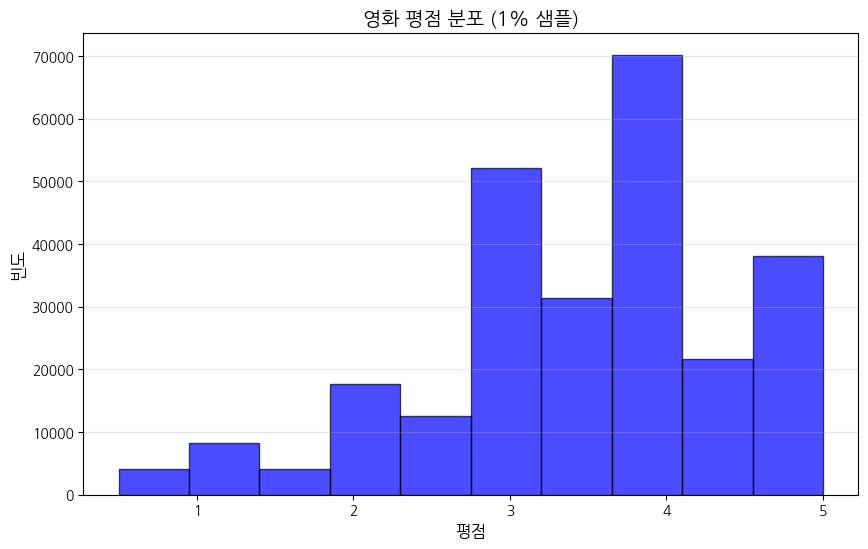

In [25]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

# Spark DataFrame을 Pandas DataFrame으로 변환
pandas_df = result.toPandas()

plt.figure(figsize=(10, 6))

# 히스토그램 그리기
plt.hist(pandas_df['rating'],   # 평점 데이터
         bins=10,                # 10개 구간으로 분할
         color='blue',           # 막대 색상: 파란색
         alpha=0.7,              # 투명도 70% (0=투명, 1=불투명)
         edgecolor='black')      # 막대 테두리 색상: 검은색

plt.title('영화 평점 분포 (1% 샘플)', fontsize=14)
plt.xlabel('평점', fontsize=12)
plt.ylabel('빈도', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()

## 5. 데이터 결합 및 집계

### OutdoorProducts 테이블 생성

In [12]:
# 새 SparkSession (필요 시)
# spark.stop()
# spark = SparkSession.builder.appName("New EDA Session").getOrCreate()

In [27]:
# outdoorProducts 테이블 생성

# OnlineRetail.csv 파일 경로 설정
RETAIL_PATH = os.path.join(BASE, "OnlineRetail.csv")

# 기존 outdoorProducts 테이블이 있으면 삭제
spark.sql("DROP TABLE IF EXISTS outdoorProducts")

# 새로운 outdoorProducts 테이블 생성 및 CSV 데이터 로드
spark.sql(f"""
CREATE TABLE outdoorProducts (
    InvoiceNo INT,                 -- 송장 번호
    StockCode STRING,       -- 재고 코드 (상품 코드)
    Description STRING,      -- 상품 설명
    Quantity INT,                   -- 수량
    invoiceDate TIMESTAMP,  -- 송장 날짜 (구매 날짜)
    UnitPrice DOUBLE,       -- 단가 (개당 가격)
    CustomerID INT,            -- 고객 ID
    Country STRING            -- 국가
)
USING csv                   -- CSV 형식 사용
OPTIONS (
    path '{RETAIL_PATH}',   -- 파일 경로
    header 'true'           -- 첫 번째 행을 헤더로 사용
)
""")

DataFrame[]

In [28]:
spark.sql("SELECT * FROM outdoorProducts").limit(5).show()

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|invoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|       NULL|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|       NULL|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|       NULL|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|       NULL|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|       NULL|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+



In [29]:
spark.sql("SELECT COUNT(*) FROM outdoorProducts").show()

+--------+
|count(1)|
+--------+
|  541909|
+--------+



### 음수 수량 데이터 탐색

In [30]:
# quantity가 0보다 작은 행의 수 계산

# 음수 수량을 가진 레코드 개수 조회
result = spark.sql("""
SELECT COUNT(quantity) AS negative_quantity_count     -- 음수 수량 개수 집계
FROM outdoorProducts                                -- outdoorProducts 테이블에서
WHERE quantity < 0                                  -- 수량이 0보다 작은 행만 필터링
""")

# 결과 출력 (첫 번째 행의 negative_quantity_count 값 추출)
print(f"음수 수량: {result.collect()[0]['negative_quantity_count']}")

음수 수량: 10624


### Sales View 생성 (quantity > 0, totalAmount 계산)

In [31]:
# sales 임시 뷰 생성 (판매 데이터만 포함, 환불 제외)
spark.sql("""
CREATE OR REPLACE TEMPORARY VIEW sales AS
SELECT
  stockCode,                                      -- 상품 코드
  quantity,                                           -- 수량
  unitPrice,                                          -- 단가
  country AS countryName,                         -- 국가 (컬럼명을 countryName으로 변경)
  ROUND(quantity * unitPrice, 2) AS totalAmount   -- 총 금액 (수량 × 단가, 소수점 2자리)
FROM outdoorProducts
WHERE quantity > 0                                -- 양수 수량만 선택 (환불/반품 제외)
""")

DataFrame[]

In [33]:
# totalAmount 내림차순
spark.sql("SELECT * FROM sales ORDER BY totalAmount DESC").limit(5).toPandas()

,stockCode,quantity,unitPrice,countryName,totalAmount
0,23843,80995,2.08,United Kingdom,168469.60
1,23166,74215,1.04,United Kingdom,77183.60
2,22502,60,649.50,United Kingdom,38970.00
3,AMAZONFEE,1,13541.33,United Kingdom,13541.33
4,B,1,11062.06,United Kingdom,11062.06


In [35]:
# 고유 국가 목록 조회 (중복 제거) - 긴 텍스트를 자르지 않고 전체 표시
spark.sql("SELECT DISTINCT countryName FROM sales").show(truncate=False)

+------------------+
|countryName       |
+------------------+
|Sweden            |
|Singapore         |
|Germany           |
|France            |
|Greece            |
|European Community|
|Belgium           |
|Finland           |
|Malta             |
|Unspecified       |
|Italy             |
|EIRE              |
|Lithuania         |
|Norway            |
|Spain             |
|Denmark           |
|Hong Kong         |
|Iceland           |
|Israel            |
|Channel Islands   |
+------------------+
only showing top 20 rows


### 국가별 총 판매량 View

In [37]:
# salesQuants 임시 뷰 생성 (국가별 총 판매 수량 집계)
spark.sql("""
CREATE OR REPLACE TEMPORARY VIEW salesQuants AS
SELECT
  country AS countryName,                 -- 국가 (컬럼명을 countryName으로 변경)
  SUM(quantity) AS totalQuantity        -- 국가별 총 수량 합계
FROM outdoorProducts
GROUP BY country                            -- 국가별로 그룹화
ORDER BY totalQuantity DESC         -- 총 수량 기준 내림차순 정렬 (많은 순서대로)
""")

DataFrame[]

In [39]:
spark.sql("SELECT * FROM salesQuants").limit(5).toPandas()

,countryName,totalQuantity
0,United Kingdom,4263829
1,Netherlands,200128
2,EIRE,142637
3,Germany,117448
4,France,110480


### CountryCodes 테이블과 JOIN

In [40]:
# countryCodes 테이블 생성 (국가 코드 매핑 테이블)

# countries_iso3166b.csv 파일 경로 설정
COUNTRIES_PATH = os.path.join(BASE, "countries_iso3166b.csv")

# 기존 countryCodes 테이블이 있으면 삭제
spark.sql("DROP TABLE IF EXISTS countryCodes")

# 새로운 countryCodes 테이블 생성 및 CSV 데이터 로드
spark.sql(f"""
CREATE TABLE countryCodes
USING csv                      -- CSV 형식 사용
OPTIONS (
  path '{COUNTRIES_PATH}',     -- 파일 경로
  header 'true'                -- 첫 번째 행을 헤더로 사용
)
""")

DataFrame[]

In [43]:
# countryCodes 테이블의 스키마(구조) 확인 (컬럼명과 데이터 타입)
spark.sql("DESC countryCodes").toPandas()

,col_name,data_type,comment
0,iso2,string,None
1,iso3,string,None
2,iso_num,string,None
3,country,string,None
4,country_common,string,None


In [44]:
spark.sql("SELECT * FROM countryCodes").limit(5).toPandas()

,iso2,iso3,iso_num,country,country_common
0,AF,AFG,004,Afghanistan,Afghanistan
1,AX,ALA,248,Aland Islands,Aland Islands
2,AL,ALB,008,Albania,Albania
3,DZ,DZA,012,Algeria,Algeria
4,AS,ASM,016,American Samoa,American Samoa


### JOIN 및 원형 차트 시각화

In [45]:
# 국가별 판매 수량과 ISO 3166 알파3 코드 조인

# salesQuants와 countryCodes 테이블 조인하여 국가 코드 추가
result = spark.sql("""
SELECT
    sq.countryName AS countryName,      -- 국가명
    sq.totalQuantity AS totalQuantity,         -- 국가별 총 판매 수량
    cc.iso3 AS alpha3Code                         -- ISO 3166 알파3 국가 코드 (예: KOR, USA, GBR)
FROM salesQuants sq                     -- 판매 수량 뷰 (별칭 sq)
JOIN countryCodes cc                      -- 국가 코드 테이블 (별칭 cc)
  ON sq.countryName = cc.country_common -- 국가명 기준으로 조인
ORDER BY totalQuantity DESC                     -- 판매 수량 많은 순서로 정렬
""")

# 상위 10개 국가만 출력
result.limit(10).show()

+--------------+-------------+----------+
|   countryName|totalQuantity|alpha3Code|
+--------------+-------------+----------+
|United Kingdom|      4263829|       GBR|
|   Netherlands|       200128|       NLD|
|       Germany|       117448|       DEU|
|        France|       110480|       FRA|
|     Australia|        83653|       AUS|
|        Sweden|        35637|       SWE|
|   Switzerland|        30325|       CHE|
|         Spain|        26824|       ESP|
|         Japan|        25218|       JPN|
|       Belgium|        23152|       BEL|
+--------------+-------------+----------+



In [46]:
# Spark DataFrame을 Pandas DataFrame으로 변환
pandas_df = result.toPandas()

# 파이 차트용 데이터 추출
labels = pandas_df['alpha3Code']      # 국가 코드 (라벨로 사용, 예: GBR, DEU, FRA)
sizes = pandas_df['totalQuantity']      # 판매 수량 (파이 조각 크기로 사용)

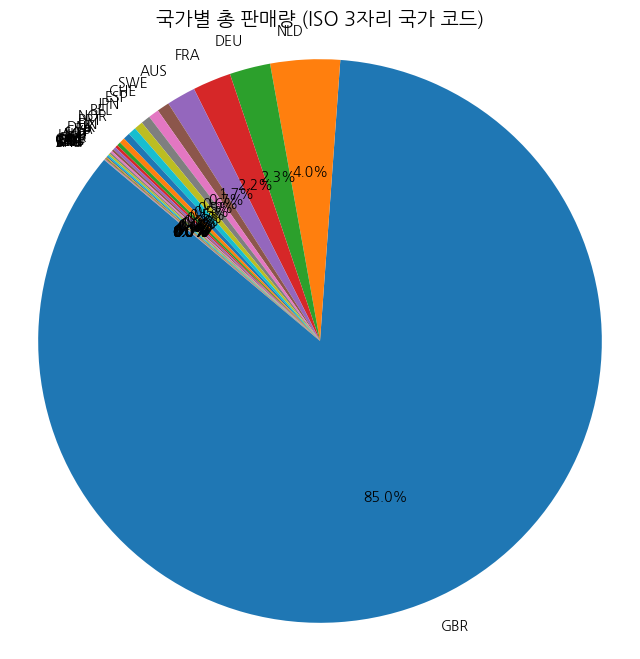

In [47]:
# 원형 차트 (파이 차트) 생성
plt.figure(figsize=(8, 8))

plt.pie(sizes,                    # 각 조각의 크기 (판매 수량)
        labels=labels,          # 각 조각의 라벨 (국가 코드)
        autopct='%1.1f%%',      # 비율 표시 (소수점 1자리, % 기호 포함)
        startangle=140)             # 시작 각도 140도 (12시 방향에서 시계 반대방향으로 회전)

plt.title('국가별 총 판매량 (ISO 3자리 국가 코드)', fontsize=14)
plt.axis('equal')  # 원형 유지 (찌그러지지 않게)
plt.show()

### 1% 이하 국가는 "Others"로 합치기

In [48]:
# 작은 조각들을 "Others"로 통합 (전체의 1% 미만 항목)

# 전체 판매량 합계 계산
total = sizes.sum()

# 임계값 설정 (전체의 1%)
threshold = total * 0.01

# 새로운 라벨과 크기를 저장할 리스트 초기화
new_labels = []
new_sizes = []

# "Others"로 통합될 작은 항목들의 합계
others_size = 0

# 각 국가별로 판매량 확인
for label, size in zip(labels, sizes):
    if size < threshold:              # 전체의 1% 미만이면
        others_size += size           # "Others" 그룹에 합산
    else:                                  # 1% 이상이면
        new_labels.append(label)      # 개별 항목으로 유지
        new_sizes.append(size)

# "Others" 그룹에 항목이 있으면 추가
if others_size > 0:
    new_labels.append("Others")       # "Others" 라벨 추가
    new_sizes.append(others_size)     # 통합된 크기 추가

# 결과 출력 (확인용)
print(f"Labels: {new_labels}")
print(f"Sizes: {new_sizes}")

Labels: ['GBR', 'NLD', 'DEU', 'FRA', 'AUS', 'Others']
Sizes: [4263829, 200128, 117448, 110480, 83653, 243021]


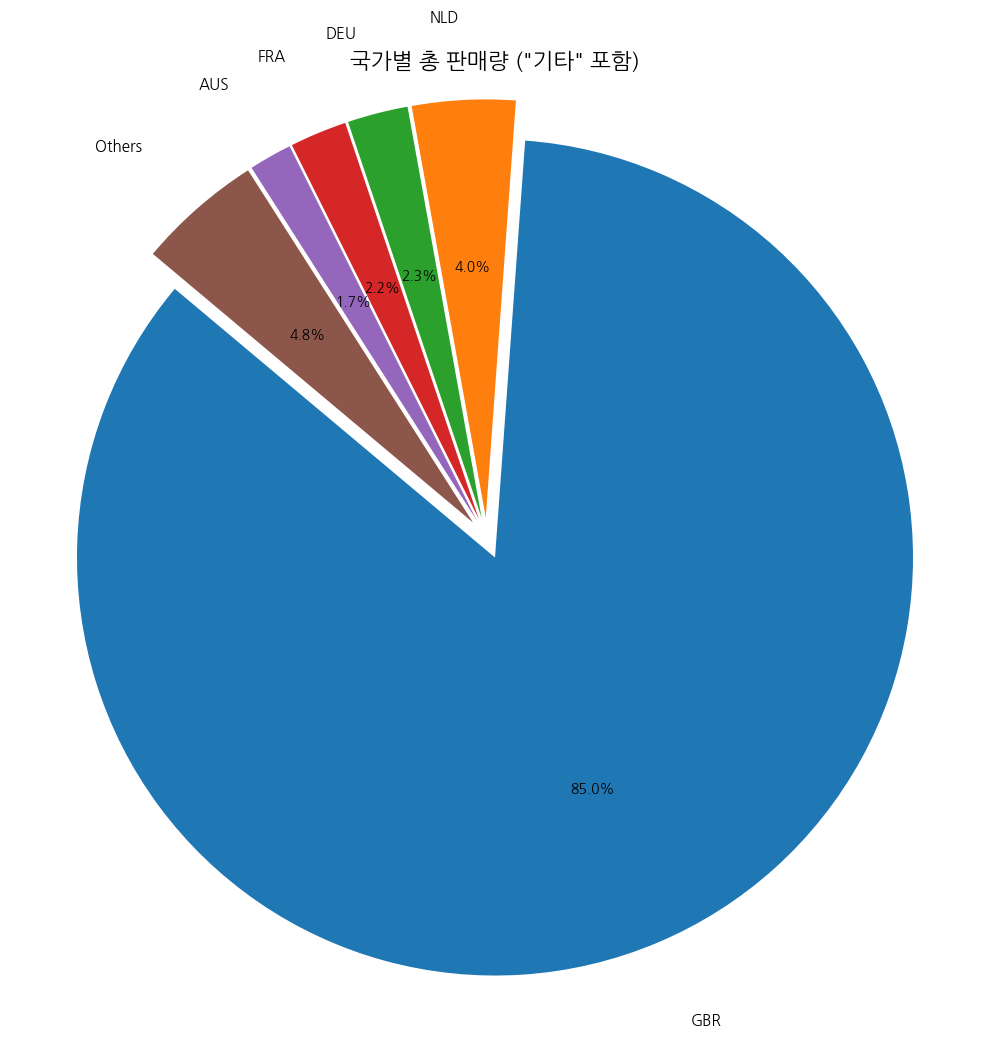

In [49]:
# 분리된 원형 차트 (각 조각이 약간씩 떨어져 있음)

plt.figure(figsize=(10, 10))

# 각 조각을 중심에서 떨어뜨리는 정도 설정 (모든 조각 0.05만큼 분리)
explode = [0.05] * len(new_labels)

# 파이 차트 그리기 (wedges: 조각, texts: 라벨, autotexts: 퍼센트 텍스트)
wedges, texts, autotexts = plt.pie(
    new_sizes,                      # 각 조각의 크기
    labels=new_labels,          # 각 조각의 라벨
    autopct='%1.1f%%',          # 비율 표시 (소수점 1자리)
    explode=explode,            # 조각 분리 정도
    labeldistance=1.2,           # 라벨 위치 (중심에서의 거리, 1.0보다 크면 바깥쪽)
    startangle=140                # 시작 각도
)

# 라벨 텍스트 크기 조정
for text in texts:
    text.set_fontsize(11)       # 국가 코드 라벨 폰트 크기 11

# 퍼센트 텍스트 크기 조정
for autotext in autotexts:
    autotext.set_fontsize(10)   # 퍼센트 표시 폰트 크기 10

plt.title('국가별 총 판매량 ("기타" 포함)', fontsize=16)
plt.axis('equal')   # 원형 유지 (찌그러지지 않게)
plt.tight_layout()  # 여백 자동 조정 (제목이나 라벨이 잘리지 않게)
plt.show()

In [50]:
spark.stop()